## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [5]:
path='/home/borowis/s3/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [6]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Just for display purposes, let's read in the movie names too.

In [7]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [8]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


## Collaborative filtering

In [9]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [10]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [11]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

  6%|▋         | 79/1261 [00:00<00:03, 381.11it/s, loss=1.62, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss                                             
    0      0.774354   0.769929  
    1      0.701245   0.754226                                             
    2      0.59122    0.738449                                             



[0.7384492717459802]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [14]:
math.sqrt(0.738)

0.8590692637965812

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [15]:
preds = learn.predict()

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


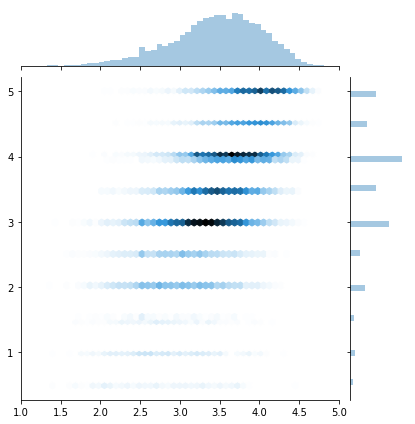

In [16]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [17]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [18]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(610, 50)
  (i): Embedding(9724, 50)
  (ub): Embedding(610, 1)
  (ib): Embedding(9724, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [22]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [24]:
movie_bias

array([[ 0.91177],
       [ 1.29642],
       [ 0.88269],
       ...,
       [-0.25971],
       [ 0.09314],
       [ 0.08991]], dtype=float32)

In [25]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [26]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.679764, 'Karate Kid, Part III, The (1989)'),
 (-0.67213863, 'Anaconda (1997)'),
 (-0.6692383, 'Speed 2: Cruise Control (1997)'),
 (-0.6670404, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.6598207, 'Problem Child (1990)'),
 (-0.63787407, 'Godzilla (1998)'),
 (-0.6377954, 'Jason X (2002)'),
 (-0.62573034, 'Catwoman (2004)'),
 (-0.6147568, 'Batman & Robin (1997)'),
 (-0.60897124, 'Honey, I Blew Up the Kid (1992)'),
 (-0.60819775, 'Spice World (1997)'),
 (-0.5909927, 'Stuart Saves His Family (1995)'),
 (-0.58866984, 'Battlefield Earth (2000)'),
 (-0.58812857, 'Volcano (1997)'),
 (-0.57150877, 'Superman IV: The Quest for Peace (1987)')]

In [27]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.679764, 'Karate Kid, Part III, The (1989)'),
 (-0.67213863, 'Anaconda (1997)'),
 (-0.6692383, 'Speed 2: Cruise Control (1997)'),
 (-0.6670404, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.6598207, 'Problem Child (1990)'),
 (-0.63787407, 'Godzilla (1998)'),
 (-0.6377954, 'Jason X (2002)'),
 (-0.62573034, 'Catwoman (2004)'),
 (-0.6147568, 'Batman & Robin (1997)'),
 (-0.60897124, 'Honey, I Blew Up the Kid (1992)'),
 (-0.60819775, 'Spice World (1997)'),
 (-0.5909927, 'Stuart Saves His Family (1995)'),
 (-0.58866984, 'Battlefield Earth (2000)'),
 (-0.58812857, 'Volcano (1997)'),
 (-0.57150877, 'Superman IV: The Quest for Peace (1987)')]

In [28]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.2964165, 'Shawshank Redemption, The (1994)'),
 (0.9623814,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.939315, 'Casablanca (1942)'),
 (0.911769, 'Forrest Gump (1994)'),
 (0.90257126, 'Usual Suspects, The (1995)'),
 (0.89892083, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.8937338, 'Princess Bride, The (1987)'),
 (0.884867, 'Fight Club (1999)'),
 (0.8826883, 'Pulp Fiction (1994)'),
 (0.8763097, 'Dark Knight, The (2008)'),
 (0.8724095, "Schindler's List (1993)"),
 (0.8546282, 'Eternal Sunshine of the Spotless Mind (2004)'),
 (0.84073365, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.8381189, 'Godfather, The (1972)'),
 (0.8328609, 'Goodfellas (1990)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [29]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [31]:
movie_pca.shape

(3, 3000)

In [32]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10015010873890039, 'Pulp Fiction (1994)'),
 (0.0881661395906791, 'Godfather, The (1972)'),
 (0.08529689253942802, 'Big Lebowski, The (1998)'),
 (0.0767408964650162, 'Memento (2000)'),
 (0.07203572217311736, "Schindler's List (1993)"),
 (0.06713773240045026, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.0656368098418663, 'Godfather: Part II, The (1974)'),
 (0.06533905514442585, 'Monty Python and the Holy Grail (1975)'),
 (0.0638487016954526, 'Requiem for a Dream (2000)'),
 (0.06141398864974286, 'Kill Bill: Vol. 1 (2003)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.07457483317583867, 'Twister (1996)'),
 (-0.0639979933248899, 'Congo (1995)'),
 (-0.058528687193786795, 'Broken Arrow (1996)'),
 (-0.05659395083142353, "Big Momma's House (2000)"),
 (-0.05609607889422268, 'Lara Croft: Tomb Raider (2001)'),
 (-0.05286701774440984, 'Jason X (2002)'),
 (-0.04960817404239116, 'Bone Collector, The (1999)'),
 (-0.04923671030407745, 'Anaconda (1997)'),
 (-0.04837560956153961, 'The Scorpion King (2002)'),
 (-0.047158271574786866, 'Richie Rich (1994)')]

In [35]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [36]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06698591729559031, "Boys Don't Cry (1999)"),
 (0.062268788799000586, 'Mulholland Drive (2001)'),
 (0.060312262487833675, 'Natural Born Killers (1994)'),
 (0.05999669565053869, 'Blair Witch Project, The (1999)'),
 (0.04889410099591842, 'Election (1999)'),
 (0.04839696182932077, 'Blue Velvet (1986)'),
 (0.04724300963640263, 'Age of Innocence, The (1993)'),
 (0.04614004013239316, 'Battlefield Earth (2000)'),
 (0.045891096617720215, 'Kill Bill: Vol. 2 (2004)'),
 (0.04489463456921062, 'Bowfinger (1999)')]

In [37]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.1079311043354142, 'Back to the Future (1985)'),
 (-0.09479282629018496, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (-0.09333571465517013,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.08900375079858434, 'Speed (1994)'),
 (-0.08542542114471792, 'Braveheart (1995)'),
 (-0.07916022093997616, 'Forrest Gump (1994)'),
 (-0.07900672519360881, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.07809638154369235, 'Armageddon (1998)'),
 (-0.07736609168139562, 'Jurassic Park (1993)'),
 (-0.07482901825881859, 'Matrix, The (1999)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

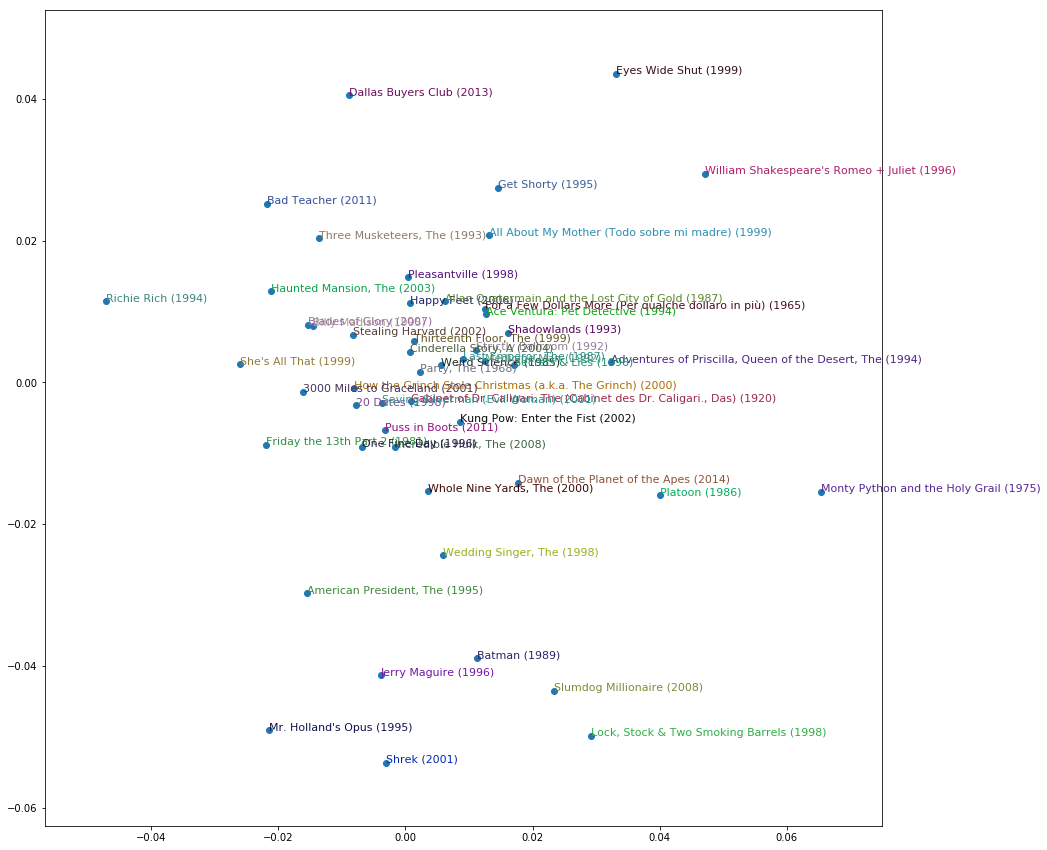

In [39]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [40]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(tensor([[1., 2.],
         [3., 4.]], device='cuda:0'), tensor([[ 2.,  2.],
         [10., 10.]], device='cuda:0'))

In [41]:
a*b

tensor([[ 2.,  4.],
        [30., 40.]], device='cuda:0')

In [42]:
(a*b).sum(1)

tensor([ 6., 70.], device='cuda:0')

In [43]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [44]:
model=DotProduct()

In [45]:
model(a,b)

tensor([ 6., 70.], device='cuda:0')

### Dot product model

In [46]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [48]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1).view(-1, 1)

In [49]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [50]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [51]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [52]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                            
    0      1.652418   1.597836  
    1      1.068461   1.292006                                            
    2      0.877866   1.224236                                             



[1.2242355574611963]

In [53]:
set_lrs(opt, 0.01)

In [54]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                             
    0      0.693461   1.153889  
    1      0.664925   1.143126                                             
    2      0.638829   1.137968                                             



[1.1379681197582727]

### Bias

In [55]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [56]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res.view(-1, 1)

In [57]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [58]:
fit(model, data, 3, opt, F.mse_loss)

  7%|▋         | 94/1261 [00:00<00:02, 459.69it/s, loss=1.19, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss                                             
    0      0.800038   0.817919  
    1      0.774573   0.794451                                             
    2      0.765466   0.792181                                             



[0.7921807645196782]

In [59]:
set_lrs(opt, 1e-2)

In [60]:
fit(model, data, 3, opt, F.mse_loss)

  7%|▋         | 91/1261 [00:00<00:02, 435.82it/s, loss=0.727, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss                                             
    0      0.690642   0.781521  
    1      0.719436   0.780483                                             
    2      0.710044   0.779838                                             



[0.7798384394020651]

### Mini net

In [67]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating) + min_rating

In [68]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [69]:
fit(model, data, 3, opt, F.mse_loss)

  5%|▌         | 67/1261 [00:00<00:03, 317.90it/s, loss=1.93, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss                                             
    0      0.884026   0.791244  
    1      0.809893   0.776638                                             
    2      0.796272   0.775144                                             



[0.7751443152101498]

In [70]:
set_lrs(opt, 1e-3)

In [71]:
fit(model, data, 3, opt, F.mse_loss)

  6%|▌         | 73/1261 [00:00<00:03, 346.15it/s, loss=0.73, refresh=0] 

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss                                             
    0      0.77983    0.770619  
    1      0.775084   0.769509                                             
    2      0.737982   0.777307                                             



[0.7773069907098945]